# Stock Prices Multivariate LSTM

[Multivariate LSTM, Machine Learning Mastery](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)


In [1]:
import numpy as np
import random
np.random.seed(15)
random.seed(15)
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import requests
import json

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# Load yahoo data
target = 'AMZN'
indexes = ['IAU', 'BNDX', 'SPY', 'VIXY', 'VGK', 'VNQ', 'VOO', 'VSS', 'VT', 'OIL', 'VWO', '^N225']
companies = ['AAPL', 'FB', 'NFLX', 'TSLA', 'MSFT']
companies.append(target)
tickers = indexes + companies

start = dt.datetime(2014,1,1)
end = dt.datetime.now()
prediction_days = 60

data = pdr.DataReader(tickers, 'yahoo', start, end)
data = data['Close'].dropna()
data.head()

Symbols,IAU,BNDX,SPY,VIXY,VGK,VNQ,VOO,VSS,VT,OIL,VWO,^N225,AAPL,FB,NFLX,TSLA,MSFT,AMZN
Date,,,,,,,,,,,,,,,,,,
2014-01-06,12.01,49.720001,182.360001,571.200012,57.610001,65.260002,167.059998,102.370003,58.419998,42.220001,39.270000,15908.879883,19.426071,57.200001,51.367142,29.400000,36.130001,393.630005
2014-01-07,11.95,49.840000,183.479996,558.599976,58.000000,65.550003,168.100006,102.660004,58.689999,42.220001,39.430000,15814.370117,19.287144,57.919998,48.500000,29.872000,36.410000,398.029999
2014-01-08,11.89,49.720001,183.520004,559.599976,57.970001,65.230003,168.169998,102.639999,58.700001,39.810001,39.360001,16121.450195,19.409286,58.230000,48.712856,30.256001,35.759998,401.920013
2014-01-09,11.92,49.759998,183.639999,560.599976,58.020000,65.230003,168.270004,102.440002,58.689999,39.810001,39.110001,15880.330078,19.161428,57.220001,48.150002,29.506001,35.529999,401.010010
2014-01-10,12.09,49.889999,184.139999,547.400024,58.590000,66.120003,168.660004,103.820000,59.090000,39.810001,39.869999,15912.059570,19.033571,57.939999,47.448570,29.143999,36.040001,397.660004


In [3]:
# Load fred data

!pip install fredapi
from fredapi import Fred

fred = Fred(api_key='1200efa1d4a1d7803f37bbd760977ddc')

T10Y2Y = fred.get_series('T10Y2Y', observation_start=start, observation_end=end) # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
T10Y2Y = T10Y2Y.to_frame()
T10Y2Y.columns = ['T10Y2Y']

T10YIE = fred.get_series('T10YIE', observation_start=start, observation_end=end) # 10-Year Breakeven Inflation Rate
T10YIE = T10YIE.to_frame()
T10YIE.columns = ['T10YIE']

T5YIE = fred.get_series('T5YIE', observation_start=start, observation_end=end) # 5-Year Breakeven Inflation Rate
T5YIE = T5YIE.to_frame()
T5YIE.columns = ['T5YIE']

T5YIFR = fred.get_series('T5YIFR', observation_start=start, observation_end=end) # 5-Year, 5-Year Forward Inflation Expectation Rate
T5YIFR = T5YIFR.to_frame()
T5YIFR.columns = ['T5YIFR']

DJIA = fred.get_series('DJIA', observation_start=start, observation_end=end) # Dow Jones Industrial Average
DJIA = DJIA.to_frame()
DJIA.columns = ['DJIA']

NASDAQCOM = fred.get_series('NASDAQCOM', observation_start=start, observation_end=end) # NASDAQ Composite Index
NASDAQCOM = NASDAQCOM.to_frame()
NASDAQCOM.columns = ['NASDAQCOM']

data_frames = [T10Y2Y, T10YIE, T5YIE, T5YIFR, DJIA, NASDAQCOM]

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True, how='inner'), data_frames).dropna()
df_merged = df_merged.rename_axis('Date')
df_merged.tail()

,T10Y2Y,T10YIE,T5YIE,T5YIFR,DJIA,NASDAQCOM
Date,,,,,,
2021-03-17,1.50,2.30,2.58,2.02,33015.37,13525.20
2021-03-18,1.55,2.27,2.50,2.04,32862.30,13116.17
2021-03-19,1.58,2.31,2.51,2.11,32627.97,13215.24
2021-03-22,1.54,2.33,2.51,2.15,32731.20,13377.54
2021-03-23,1.48,2.29,2.48,2.10,32423.15,13227.70


In [4]:
dfraw = df_merged.join(data)
dfraw.dropna().tail()

,T10Y2Y,T10YIE,T5YIE,T5YIFR,DJIA,NASDAQCOM,IAU,BNDX,SPY,VIXY,VGK,VNQ,VOO,VSS,VT,OIL,VWO,^N225,AAPL,FB,NFLX,TSLA,MSFT,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-17,1.50,2.30,2.58,2.02,33015.37,13525.20,16.620001,57.099998,397.260010,10.30,63.959999,92.680000,365.239990,131.199997,98.580002,18.760000,53.110001,29914.330078,124.760002,284.010010,524.440002,701.809998,237.039993,3135.729980
2021-03-18,1.55,2.27,2.50,2.04,32862.30,13116.17,16.530001,56.980000,391.480011,10.89,63.169998,91.739998,359.869995,129.039993,97.139999,17.459999,52.290001,30216.750000,120.529999,278.619995,504.790009,653.159973,230.720001,3027.989990
2021-03-19,1.58,2.31,2.51,2.11,32627.97,13215.24,16.610001,57.080002,389.480011,10.54,63.209999,90.489998,359.230011,130.470001,97.239998,18.010000,52.810001,29792.050781,119.989998,290.109985,512.179993,654.869995,230.350006,3074.959961
2021-03-22,1.54,2.33,2.51,2.15,32731.20,13377.54,16.570000,57.130001,392.589996,9.75,63.160000,91.129997,362.070007,130.300003,97.419998,17.950001,52.630001,29174.150391,123.389999,293.540009,523.109985,670.000000,235.990005,3110.870117
2021-03-23,1.48,2.29,2.48,2.10,32423.15,13227.70,16.440001,57.279999,389.500000,10.25,62.240002,91.000000,359.410004,127.690002,96.209999,17.040001,51.770000,28995.919922,122.540001,290.630005,535.090027,662.159973,237.580002,3137.500000


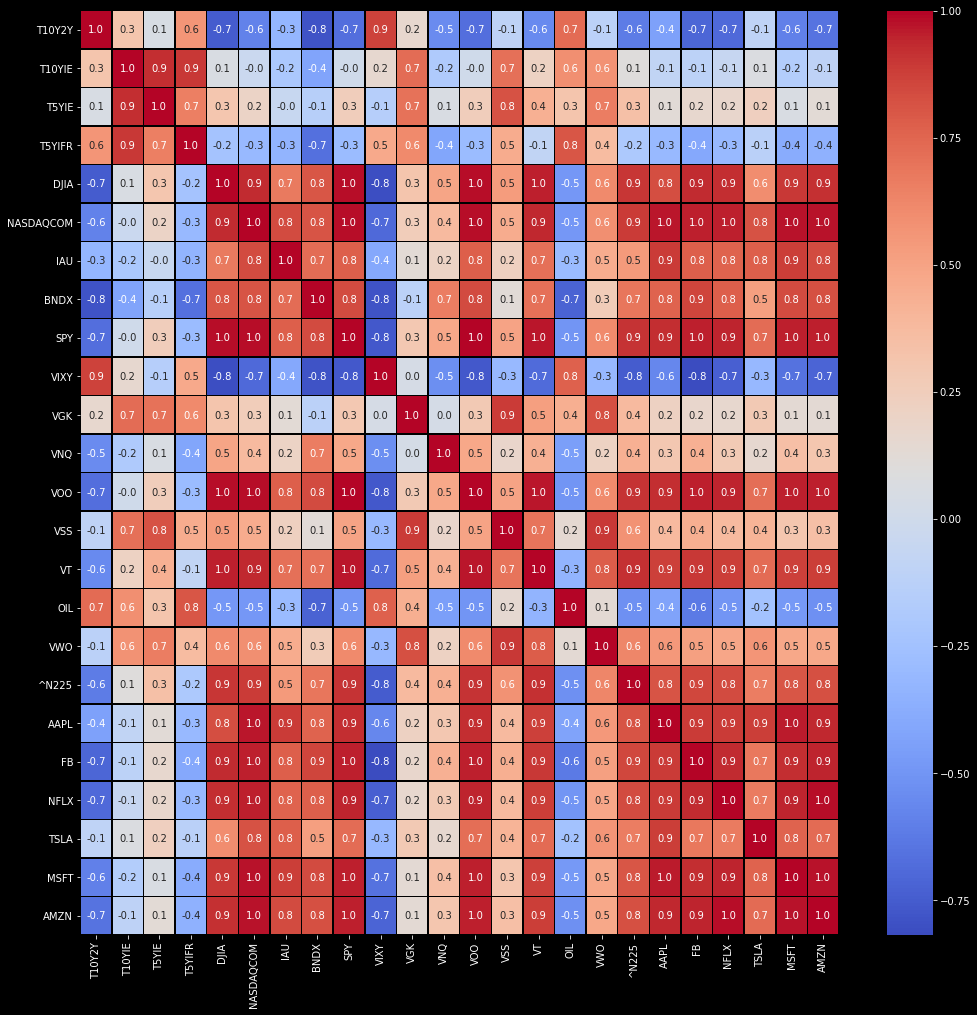

In [5]:
import seaborn as sns
plt.style.use('dark_background')
f,ax = plt.subplots(figsize=(17, 17))
sns.heatmap(dfraw.corr(), annot=True, linewidths=0.5,linecolor="black", fmt= '.1f',ax=ax,cmap="coolwarm")
plt.show()

In [6]:
i = 0
for n in dfraw.columns.values:
  n = str(n) + '(t)'
  dfraw.columns.values[i] = n
  i += 1

dfraw[f'{target} (t+1)'] = dfraw[target]
dfraw[f'{target} (t+1)'] = dfraw[f'{target} (t+1)'].shift(-1)

dfraw.tail(1)[f'{target} (t+1)'].fillna((float(0)), inplace=True)

dfraw.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,T10Y2Y(t),T10YIE(t),T5YIE(t),T5YIFR(t),DJIA(t),NASDAQCOM(t),IAU(t),BNDX(t),SPY(t),VIXY(t),VGK(t),VNQ(t),VOO(t),VSS(t),VT(t),OIL(t),VWO(t),^N225(t),AAPL(t),FB(t),NFLX(t),TSLA(t),MSFT(t),AMZN(t),AMZN (t+1)
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-17,1.50,2.30,2.58,2.02,33015.37,13525.20,16.620001,57.099998,397.260010,10.30,63.959999,92.680000,365.239990,131.199997,98.580002,18.760000,53.110001,29914.330078,124.760002,284.010010,524.440002,701.809998,237.039993,3135.729980,3027.989990
2021-03-18,1.55,2.27,2.50,2.04,32862.30,13116.17,16.530001,56.980000,391.480011,10.89,63.169998,91.739998,359.869995,129.039993,97.139999,17.459999,52.290001,30216.750000,120.529999,278.619995,504.790009,653.159973,230.720001,3027.989990,3074.959961
2021-03-19,1.58,2.31,2.51,2.11,32627.97,13215.24,16.610001,57.080002,389.480011,10.54,63.209999,90.489998,359.230011,130.470001,97.239998,18.010000,52.810001,29792.050781,119.989998,290.109985,512.179993,654.869995,230.350006,3074.959961,3110.870117
2021-03-22,1.54,2.33,2.51,2.15,32731.20,13377.54,16.570000,57.130001,392.589996,9.75,63.160000,91.129997,362.070007,130.300003,97.419998,17.950001,52.630001,29174.150391,123.389999,293.540009,523.109985,670.000000,235.990005,3110.870117,3137.500000
2021-03-23,1.48,2.29,2.48,2.10,32423.15,13227.70,16.440001,57.279999,389.500000,10.25,62.240002,91.000000,359.410004,127.690002,96.209999,17.040001,51.770000,28995.919922,122.540001,290.630005,535.090027,662.159973,237.580002,3137.500000,0.000000


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_raw = scaler.fit_transform(dfraw.values)
scaled_data_raw[-1]

array([5.73584906e-01, 9.78142077e-01, 9.55102041e-01, 6.26262626e-01,
       9.66432328e-01, 9.14069501e-01, 6.57949923e-01, 7.95789217e-01,
       9.65215790e-01, 7.04771290e-04, 9.35964357e-01, 7.99109242e-01,
       9.71648170e-01, 9.44776673e-01, 9.47078744e-01, 2.45767091e-01,
       8.31066542e-01, 9.11108435e-01, 8.35449010e-01, 9.46960626e-01,
       9.05347258e-01, 7.41407509e-01, 9.64623301e-01, 8.78579147e-01,
       0.00000000e+00])

In [8]:
# df = df.pct_change()
df = dfraw.dropna()
df.drop(df.tail(1).index, inplace=True)
df.shape
# df.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1621, 25)

In [9]:
# Using random days as test data
train_size = 0.90
train_df = df.drop(index=random.sample(list(df.index), round(df.shape[0]*(1-train_size))))
test_df = df.loc[random.sample(list(df.index), round(df.shape[0]*(1-train_size)))]

train = scaled_train = scaler.fit_transform(train_df)
test = scaled_test = scaler.fit_transform(test_df)

# Using last days as test data

'''
scaled_data = scaler.fit_transform(df.values)

# split into train and test sets
values = scaled_data
train_size = 0.95 # testing only on the very last prices

n_train = round(df.shape[0]*train_size)

train = values[:n_train, :]
test = values[n_train:, :]
'''

'\nscaled_data = scaler.fit_transform(df.values)\n\n# split into train and test sets\nvalues = scaled_data\ntrain_size = 0.95 # testing only on the very last prices\n\nn_train = round(df.shape[0]*train_size)\n\ntrain = values[:n_train, :]\ntest = values[n_train:, :]\n'

In [10]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1459, 1, 24) (1459,) (162, 1, 24) (162,)


In [11]:
# design network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# model.save
# model.load

# fit network
print(model.summary(), '\n')
history = model.fit(train_X, train_y, epochs=15, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             15000     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

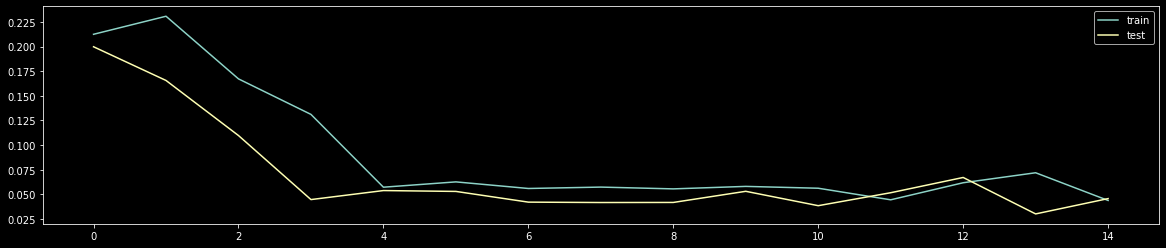

In [12]:
# plot history
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape((test_X.shape[0], inv_yhat.shape[1])))
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
inv_y = concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y.reshape((inv_y.shape[0], inv_y.shape[1])))
inv_y = inv_y[:,-1]

# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

Test RMSE: 159.715948


In [14]:
# Output

# date = df.index[df['AMZN (t+1)'] == df.values[-1][-1]].date[0] + dt.timedelta(days=1)
date = test_df.index[test_df['AMZN (t+1)'] == test_df.values[-1][-1]].date[0] + dt.timedelta(days=1)
prediction = round(float(inv_yhat[-1]), 2)

print('Prediction:')
print(f'{date} {target} {prediction}')

Prediction:
2016-11-10 AMZN 634.15


In [15]:
scaled_last_row = np.delete(scaled_data_raw[-1], -1)
scaled_last_row = scaled_last_row.reshape(1, 1, scaled_last_row.shape[0])

prediction = model.predict(scaled_last_row)
scaled_last_row = scaled_last_row.reshape(1, scaled_last_row.shape[2])

full_last_row = concatenate((scaled_last_row, prediction), axis=1)
full_last_row.shape
inv_prediction = scaler.inverse_transform(full_last_row)
inv_prediction = inv_prediction[:,-1]

date_t = dfraw.tail(1).index.date[0]
price_t = round(float(dfraw.tail(1)['AMZN(t)']), 2)

date_t1 = dfraw.tail(1).index.date[0] + dt.timedelta(days=1)
prediction = round(float(inv_prediction[0]), 2)

print('Price (t):')
print(f'{date_t} {target} {price_t} \n')

print('Price (t+1):')
print(f'{date_t1} {target} {prediction}')

Price (t):
2021-03-23 AMZN 3137.5 

Price (t+1):
2021-03-24 AMZN 2880.76


# Feature Importance

[Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

[Deep Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=deepexplainer)


 AttributeError: 'TFDeep' object has no attribute 'between_tensors'

[TFDeepExplainer broken with TF2.1.0]( https://github.com/slundberg/shap/issues/1055)

Sadly to resolve this error I should downgrade tensorflow and keras and I don't intend to do so.

In [16]:
'''
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=deepexplainer

!pip install shap
import shap
import tensorflow.keras.backend 
background = train_X[np.random.choice(train_X.shape[0], 100, replace=False)]# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)
'''

'\n# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d\n# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=deepexplainer\n\n!pip install shap\nimport shap\nimport tensorflow.keras.backend \nbackground = train_X[np.random.choice(train_X.shape[0], 100, replace=False)]# we use the first 100 training examples as our background dataset to integrate over\nexplainer = shap.DeepExplainer(model, background)\nshap_values = explainer.shap_values(train_X)\nshap.summary_plot(shap_values, train_X)\n'

In [17]:
'''
#train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, train_X[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(test_X[:10])
'''

'\n#train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])\ntest_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])\n\n# we use the first 100 training examples as our background dataset to integrate over\nexplainer = shap.DeepExplainer(model, train_X[:100])\n\n# explain the first 10 predictions\n# explaining each prediction requires 2 * background dataset size runs\nshap_values = explainer.shap_values(test_X[:10])\n'

# Prophet

In [18]:
dfraw = df_merged.join(data)
dfraw = dfraw.dropna()
dfraw.tail()

,T10Y2Y,T10YIE,T5YIE,T5YIFR,DJIA,NASDAQCOM,IAU,BNDX,SPY,VIXY,VGK,VNQ,VOO,VSS,VT,OIL,VWO,^N225,AAPL,FB,NFLX,TSLA,MSFT,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-17,1.50,2.30,2.58,2.02,33015.37,13525.20,16.620001,57.099998,397.260010,10.30,63.959999,92.680000,365.239990,131.199997,98.580002,18.760000,53.110001,29914.330078,124.760002,284.010010,524.440002,701.809998,237.039993,3135.729980
2021-03-18,1.55,2.27,2.50,2.04,32862.30,13116.17,16.530001,56.980000,391.480011,10.89,63.169998,91.739998,359.869995,129.039993,97.139999,17.459999,52.290001,30216.750000,120.529999,278.619995,504.790009,653.159973,230.720001,3027.989990
2021-03-19,1.58,2.31,2.51,2.11,32627.97,13215.24,16.610001,57.080002,389.480011,10.54,63.209999,90.489998,359.230011,130.470001,97.239998,18.010000,52.810001,29792.050781,119.989998,290.109985,512.179993,654.869995,230.350006,3074.959961
2021-03-22,1.54,2.33,2.51,2.15,32731.20,13377.54,16.570000,57.130001,392.589996,9.75,63.160000,91.129997,362.070007,130.300003,97.419998,17.950001,52.630001,29174.150391,123.389999,293.540009,523.109985,670.000000,235.990005,3110.870117
2021-03-23,1.48,2.29,2.48,2.10,32423.15,13227.70,16.440001,57.279999,389.500000,10.25,62.240002,91.000000,359.410004,127.690002,96.209999,17.040001,51.770000,28995.919922,122.540001,290.630005,535.090027,662.159973,237.580002,3137.500000


In [19]:
i = 0
x = 1
for n in dfraw.columns.values:
  n = 'add' + str(x)
  dfraw.columns.values[i] = n
  i += 1
  x += 1

dfraw['y'] = dfraw[target]
dfraw['y'] = dfraw['y'].shift(-1)

dfraw.tail(1)['y'].fillna((float(0)), inplace=True)

dfraw.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,add1,add2,add3,add4,add5,add6,add7,add8,add9,add10,add11,add12,add13,add14,add15,add16,add17,add18,add19,add20,add21,add22,add23,add24,y
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-17,1.50,2.30,2.58,2.02,33015.37,13525.20,16.620001,57.099998,397.260010,10.30,63.959999,92.680000,365.239990,131.199997,98.580002,18.760000,53.110001,29914.330078,124.760002,284.010010,524.440002,701.809998,237.039993,3135.729980,3027.989990
2021-03-18,1.55,2.27,2.50,2.04,32862.30,13116.17,16.530001,56.980000,391.480011,10.89,63.169998,91.739998,359.869995,129.039993,97.139999,17.459999,52.290001,30216.750000,120.529999,278.619995,504.790009,653.159973,230.720001,3027.989990,3074.959961
2021-03-19,1.58,2.31,2.51,2.11,32627.97,13215.24,16.610001,57.080002,389.480011,10.54,63.209999,90.489998,359.230011,130.470001,97.239998,18.010000,52.810001,29792.050781,119.989998,290.109985,512.179993,654.869995,230.350006,3074.959961,3110.870117
2021-03-22,1.54,2.33,2.51,2.15,32731.20,13377.54,16.570000,57.130001,392.589996,9.75,63.160000,91.129997,362.070007,130.300003,97.419998,17.950001,52.630001,29174.150391,123.389999,293.540009,523.109985,670.000000,235.990005,3110.870117,3137.500000
2021-03-23,1.48,2.29,2.48,2.10,32423.15,13227.70,16.440001,57.279999,389.500000,10.25,62.240002,91.000000,359.410004,127.690002,96.209999,17.040001,51.770000,28995.919922,122.540001,290.630005,535.090027,662.159973,237.580002,3137.500000,0.000000


In [20]:
df = dfraw.dropna()
df.reset_index(level = 0, inplace = True)
df.rename(columns={'Date': 'ds'}, inplace = True)
next_day = df.tail(1)
df.drop(next_day.index, inplace=True)
df.tail()

,ds,add1,add2,add3,add4,add5,add6,add7,add8,add9,add10,add11,add12,add13,add14,add15,add16,add17,add18,add19,add20,add21,add22,add23,add24,y
1694,2021-03-16,1.47,2.30,2.59,2.01,32825.95,13471.57,16.510000,57.209999,395.910004,10.79,63.630001,92.599998,364.049988,130.649994,98.160004,18.820000,53.070000,29921.089844,125.570000,279.279999,524.030029,676.880005,237.710007,3091.860107,3135.729980
1695,2021-03-17,1.50,2.30,2.58,2.02,33015.37,13525.20,16.620001,57.099998,397.260010,10.30,63.959999,92.680000,365.239990,131.199997,98.580002,18.760000,53.110001,29914.330078,124.760002,284.010010,524.440002,701.809998,237.039993,3135.729980,3027.989990
1696,2021-03-18,1.55,2.27,2.50,2.04,32862.30,13116.17,16.530001,56.980000,391.480011,10.89,63.169998,91.739998,359.869995,129.039993,97.139999,17.459999,52.290001,30216.750000,120.529999,278.619995,504.790009,653.159973,230.720001,3027.989990,3074.959961
1697,2021-03-19,1.58,2.31,2.51,2.11,32627.97,13215.24,16.610001,57.080002,389.480011,10.54,63.209999,90.489998,359.230011,130.470001,97.239998,18.010000,52.810001,29792.050781,119.989998,290.109985,512.179993,654.869995,230.350006,3074.959961,3110.870117
1698,2021-03-22,1.54,2.33,2.51,2.15,32731.20,13377.54,16.570000,57.130001,392.589996,9.75,63.160000,91.129997,362.070007,130.300003,97.419998,17.950001,52.630001,29174.150391,123.389999,293.540009,523.109985,670.000000,235.990005,3110.870117,3137.500000


In [21]:
train_size = 0.90 # testing only on the very last prices

n_train = round(df.shape[0]*train_size)

# use last days as test data

# train = df[:n_train]
# test = df[n_train:]

# use random days as test data
train = df.drop(index=list(np.random.randint(df.shape[0], size=round(df.shape[0]*(1-train_size)))))
test = df.iloc[list(np.random.randint(df.shape[0], size=round(df.shape[0]*(1-train_size))))]

In [22]:
test.tail()

,ds,add1,add2,add3,add4,add5,add6,add7,add8,add9,add10,add11,add12,add13,add14,add15,add16,add17,add18,add19,add20,add21,add22,add23,add24,y
1592,2020-10-06,0.62,1.66,1.51,1.81,27772.76,11154.605,18.00,58.119999,334.929993,20.730000,53.029999,81.860001,307.720001,106.690002,81.260002,12.130000,43.830002,23433.730469,113.160004,258.660004,505.869995,413.980011,205.910004,3099.959961,3195.689941
606,2016-07-29,0.79,1.49,1.31,1.67,18432.24,5162.130,13.02,56.099998,217.119995,135.199997,48.279999,92.449997,199.279999,97.709999,60.480000,14.410000,37.040001,16569.269531,26.052500,123.940002,91.250000,46.958000,56.680000,758.809998,767.739990
154,2014-08-26,1.87,2.14,1.83,2.45,17106.70,4570.640,12.41,52.110001,200.330002,368.600006,57.930000,76.730003,183.710007,109.629997,62.709999,41.880001,45.619999,15521.219727,25.222500,75.959999,68.480003,52.348000,45.009998,341.829987,343.179993
1611,2020-11-04,0.64,1.64,1.56,1.72,27847.66,11590.781,18.18,58.450001,343.540009,18.370001,52.509998,80.070000,315.609985,106.410004,83.010002,11.690000,45.919998,23695.230469,114.949997,287.380005,496.950012,420.980011,216.389999,3241.159912,3322.000000
292,2015-03-31,1.38,1.76,1.51,2.01,17776.12,4900.890,11.45,54.090000,206.429993,340.200012,54.220001,84.309998,189.199997,99.260002,61.590000,22.450001,40.869999,19206.990234,31.107500,82.220001,59.527142,37.754002,40.660000,372.100006,370.260010


In [23]:
from fbprophet import Prophet
prophet = Prophet()
for n in dfraw.columns.values[:len(dfraw.columns.values)-1]:
  prophet.add_regressor(n)
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


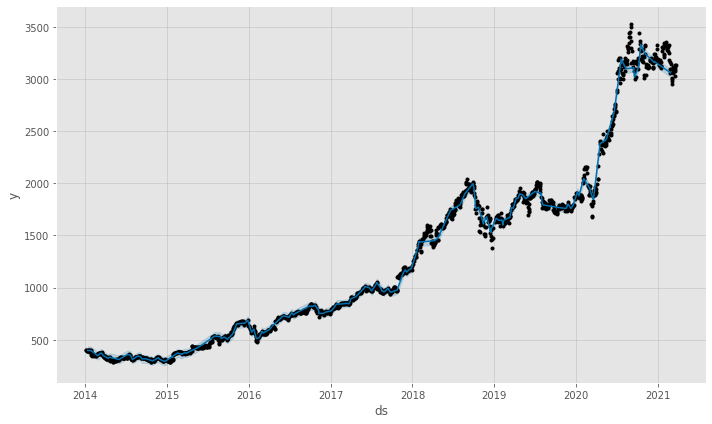

In [24]:
forecast = prophet.predict(test.drop(columns="y"))
plt.style.use('ggplot')
fig = prophet.plot(forecast)

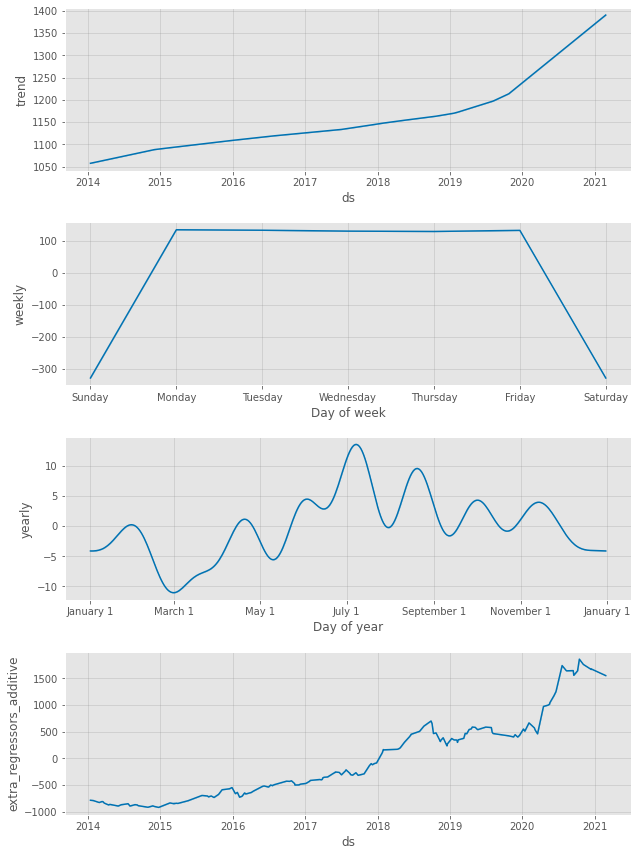

In [25]:
fig = prophet.plot_components(forecast)

In [26]:
# Python
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')

#https://facebook.github.io/prophet/docs/diagnostics.

# cutoffs = pd.to_datetime([str(x.date()) for x in list(df.tail(3)['ds'])])
# df_cv2 = cross_validation(prophet, cutoffs=cutoffs, horizon='365 days')
df_cv2 = cross_validation(prophet, horizon='365 days')

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2016-04-12 00:00:00 and 2020-03-22 00:00:00


INFO:fbprophet:Making 7 forecasts with cutoffs between 2017-03-23 00:00:00 and 2020-03-22 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,1622.913410,40.285399,26.174100,0.019152,0.011912,0.562500
1,38 days,1629.990037,40.373135,26.171649,0.019325,0.012262,0.557292
2,39 days,1758.613893,41.935831,26.999724,0.019869,0.012531,0.547619
3,40 days,1826.430115,42.736754,27.552726,0.020127,0.012575,0.538194
4,41 days,1904.707820,43.642958,27.975686,0.020371,0.012575,0.539931


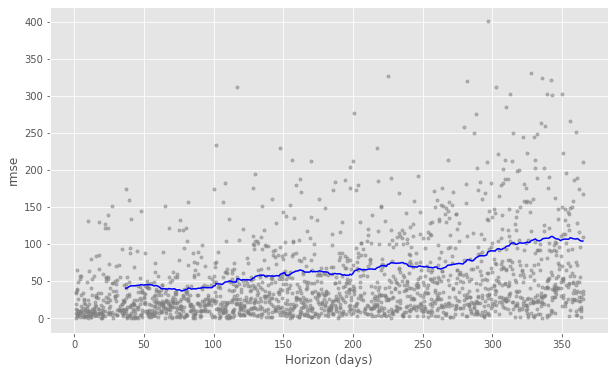

In [27]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [28]:
forecast_next_day = prophet.predict(next_day.drop(columns="y"))
forecast_next_day

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add10,add10_lower,add10_upper,add11,add11_lower,add11_upper,add12,add12_lower,add12_upper,add13,add13_lower,add13_upper,add14,add14_lower,add14_upper,add15,add15_lower,add15_upper,add16,add16_lower,add16_upper,add17,add17_lower,add17_upper,add18,add18_lower,add18_upper,add19,add19_lower,add19_upper,add2,...,add24,add24_lower,add24_upper,add3,add3_lower,add3_upper,add4,add4_lower,add4_upper,add5,add5_lower,add5_upper,add6,add6_lower,add6_upper,add7,add7_lower,add7_upper,add8,add8_lower,add8_upper,add9,add9_lower,add9_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-23,1399.897338,3111.361377,3190.787858,1399.897338,1399.897338,-11.463838,-11.463838,-11.463838,-6.308498,-6.308498,-6.308498,14.199239,14.199239,14.199239,-1.076148,-1.076148,-1.076148,236.997547,236.997547,236.997547,2.572552,2.572552,2.572552,-54.070165,-54.070165,-54.070165,2.839654,2.839654,2.839654,-2.553569,-2.553569,-2.553569,-8.186836,-8.186836,-8.186836,-18.37017,-18.37017,-18.37017,8.206737,...,1790.381866,1790.381866,1790.381866,6.607178,6.607178,6.607178,2.484201,2.484201,2.484201,26.811912,26.811912,26.811912,72.532876,72.532876,72.532876,11.562072,11.562072,11.562072,-6.029988,-6.029988,-6.029988,-274.469252,-274.469252,-274.469252,1751.751447,1751.751447,1751.751447,1626.39224,1626.39224,1626.39224,132.953062,132.953062,132.953062,-7.593856,-7.593856,-7.593856,0.0,0.0,0.0,3151.648785


In [29]:
dfraw1 = df_merged.join(data)
draw1 = dfraw1.dropna()

date_t = dfraw.tail(1).index.date[0]
price_t = round(float(dfraw1.tail(1)['AMZN']), 2)

date_t1 = dfraw.tail(1).index.date[0] + dt.timedelta(days=1)
prediction = round(float(forecast_next_day['yhat'][0]), 2)

print('Price (t):')
print(f'{date_t} {target} {price_t} \n')

print('Price (t+1):')
print(f'{date_t1} {target} {prediction}')

Price (t):
2021-03-23 AMZN 3137.5 

Price (t+1):
2021-03-24 AMZN 3151.65
